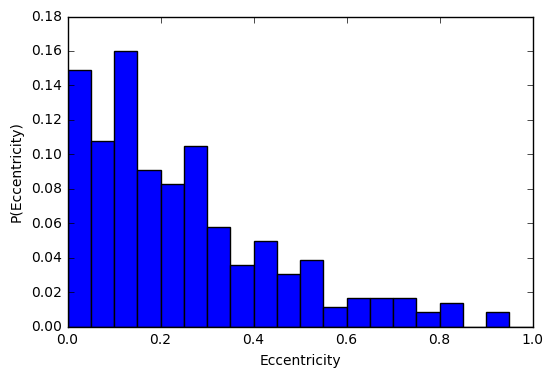

In [45]:
from astropy.table import QTable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# change the data for the kepler data, and graphs below
data = QTable.read('probecc_comma.dat',format='ascii.no_header')


data.rename_column('col1','ecc')
data.rename_column('col2','% in bin')
data.rename_column('col3','cum %')

ecc_inbin = data['% in bin']
cum=data['cum %']
binwidth = 0.05
fig,ax=plt.subplots(1,1)
bar = ax.bar(data['ecc'],ecc_inbin,width=0.05)
ax.set_xlabel('Eccentricity')
ax.set_ylabel('P(Eccentricity)')

[ 0.48299001] =r 
 (array([0, 1, 2]),) =r_mask(indices) 
 [ 0.    0.05  0.1   0.15] bins(last is right edge) 
 3 index of right edge 
    % in bin   
--------------
0.149171270718
0.256906077348
0.417127071823


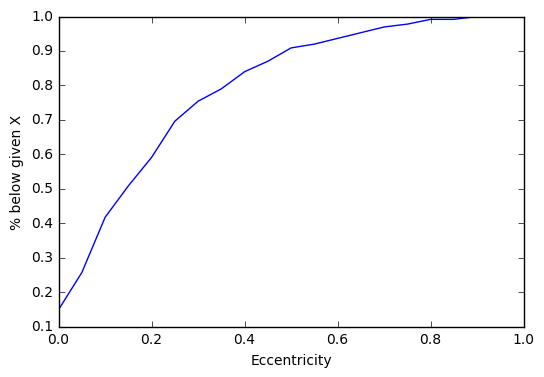

In [140]:
#data = np.random.randn(1000) # Creates random normal distribution. Change to np.random.randint() for above. 

base = data['cum %']
cumulative = data['cum %']
#cumulative = cumulative/10 # Quick fix to change to percentages.
#plt.plot(base, cumulative, c='blue')

# Sanity check, pick some range of y and spit out x and compare to original 
'''
to create cumdist, need a line where x is 0 to 1 and y is 0 to 1. 
each point is the sum of all the previous points (the third column in the data)
'''
fig,ax=plt.subplots(1,1)
x = np.arange(0,1,0.05)
y = data['cum %']
#y = np.array(y)
ax.plot(x,y,c='blue')
ax.set_xlabel('Eccentricity')
ax.set_ylabel('% below given X')

#sanity check
r = (np.random.sample(1))
if r >= 0.25 and r <= 0.75:
    r_mask = np.where(y<=r)
else:
    r_mask = np.where(y==y) # doesnt apply any masking, x_below = x
    
x_below = x[r_mask]
x_below = np.append(x_below,x_below[-1]+0.05) # to include the bin in which r belongs
max_index = np.argmax(x_below) 
max_range = x_below[-1]


# now set r = y and find all values of x that are less than that percent
#now add (% in bin) up to b_max, and compare cumsum 
sanity_check = np.cumsum(ecc_inbin[0:max_index])
print(r,'=r','\n',r_mask,'=r_mask(indices)','\n',x_below,'bins(last is right edge)','\n',max_index,'index of right edge','\n',sanity_check)

In [133]:
# make 25000 ICs w/ mass, radii, Q, ecc., period and histogram of each; 25 bins per parameter.
# 